# EDA 
reference : https://dacon.io/competitions/official/229255/codeshare/1402?page=1&dtype=recent

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import matplotlib.pylab as plt
import warnings

**Objective : 퇴근시간 승차인원을 예측하는 모델 개발**  
  
tran & test : 정류소 기준 데이터  
<변수>  
date: 날짜  
bus_route_id: 노선ID  
in_out: 시내, 시외  
station_code: 승하차 정류소의 ID  
station_name: 해당 승하차 정류소 이름 (진행방향 달라도 같음)    
latitude: 위도, longtitude: 경도 (정류소 이름 같아도 위도, 경도 다를 수 있음)  
X-Y_ride: X시동안 승차 인원수  
X-Y_takeoff: X시동안 하차 인원수  
18~20_ride: 퇴근시간 승차 인원수 (train에만 존재)  
  
bus_bts : 버스카드 기준 데이터 = 승객 기준 데이터  
<변수>  
user_card_id : 해당 승객의 버스카드ID  
*bus_route_id : 노선ID  = train & test bus_route_id* 
vhc_id: 차량ID  
geton_date: 해당 승객이 탑승한 날짜  
*geton_time: 해당 승객이 탑승한 시간 -> train & test X-Y_ride식으로 범주화*  
*geton_station_code = 승차 train & test station_code*  
*geton_station_name = 승차 train & test station_name*  
getoff_date: 해당 승객 하차 날짜  
*getoff_time: 해당 승객 하차 시간 -> train & test X-Y_takeoff식으로 범주화*  
*getoff_station_code = 하차train & test station_code*  
*getoff_station_name = 하차 train & test station_name*  
user_category: 1- 일반, 2- 어린이, 4- 청소년, 6- 경로, 27- 장애일반, 28- 장애동반, 29-유공 일반, 30- 유공 동반  
user_count: 버스카드로 계산한 인원 수

In [2]:
train = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/train.csv", encoding='utf-8')
train.set_index("id", inplace=True)
train

,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
id,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,2019-09-30,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,2019-09-30,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,2019-09-30,32820000,시내,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train.dtypes

date              object
bus_route_id       int64
in_out            object
station_code       int64
station_name      object
latitude         float64
longitude        float64
6~7_ride         float64
7~8_ride         float64
8~9_ride         float64
9~10_ride        float64
10~11_ride       float64
11~12_ride       float64
6~7_takeoff      float64
7~8_takeoff      float64
8~9_takeoff      float64
9~10_takeoff     float64
10~11_takeoff    float64
11~12_takeoff    float64
18~20_ride       float64
dtype: object

date -> 시계열? / 시간별로도 시계열?      
bus_route_id 중 유독 평균 승하차 인원이 높은 route가 있을 수도?   
in_out (-> one-hot-encoding) 
station_code, station_name : 짝짓기, 분석할 때는 station_code만 쓰고 해석할 때 station_name 참고하면 될 것 같음   
latitude, longtitude: 정수부분은 다 똑같은 것 같고, 소수점자리에서 구분해야할 듯

In [6]:
# 결측값 없음
train.isnull().sum()

date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

## 시내/시외 구분한 위도경도 산점도

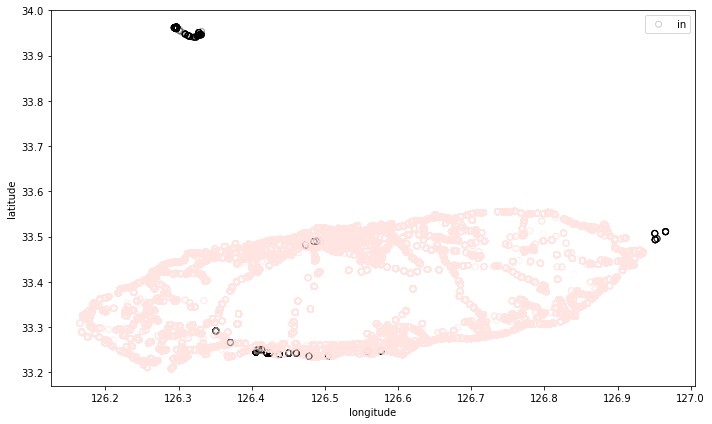

In [34]:
## latitude와 longtitude 산점도로 만들어봄
fig, ax = plt.subplots()
fig.set_size_inches(10,6)

ax.scatter(train.longitude, train.latitude, color=["mistyrose" if c=="시내" else "black" for c in train.in_out], facecolor="none", alpha=0.2)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.legend(["in"])

plt.tight_layout()
plt.show()

위도 33.9 이상인 곳은 이상치? -> 추자도 : 따로 생각하는게 좋을듯하다, 다 시외 버스  
거의 다 시내버스
모든 곳을 하나하나 일일이 볼 수 없으므로 범주화해야할 듯 하다   
-> 날씨 데이터와 함께 4개의 지역으로 구분하자! 

## station_code와 station_name

In [39]:
train["station_code"].unique()

array([ 344,  357,  432, ..., 3576, 1585, 3552], dtype=int64)

In [37]:
train["station_code"].nunique()

3563

In [40]:
train["station_code"].unique()

array([ 344,  357,  432, ..., 3576, 1585, 3552], dtype=int64)

In [38]:
train["station_name"].nunique()

1961

station code의 개수가 station name 개수의 거의 2배임: 뭐지?

In [49]:
train.groupby("station_name")["station_code"].nunique().sort_values(ascending=False).head(20)

station_name
신안동           8
금악리           7
비석거리          6
성읍1리          6
산양리           5
조수1리          5
산방산           5
신시가지          5
와흘리           4
거로입구          4
거로사거리         4
상명리           4
제주항공우주박물관     4
대천동주민센터       4
삼무공원          4
온난화대응농업연구소    4
제주국제대학교       4
삼달1리          4
월평마을          4
하도리서문동        4
Name: station_code, dtype: int64

왜인지 모르겠지만 station name은 같은데 code는 다른 것들이 꽤 많은 것 같음  
결과 해석할 때만 station_name 쓰고 분석할 때는 station_code를 쓰는게 나을 듯 하다.

## 날짜별 시계열 데이터

ride 컬럼과 takeoff 컬럼을 만드는 것이 좋을 듯함 -> 시간대별 시계열 데이터

In [50]:
# 일단 date 컬럼을 datetimeIndex로
train["date"] = pd.to_datetime(train.date, format="%Y-%m-%d")

In [72]:
train.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

### 날짜별 ride 데이터

In [75]:
date_ride = pd.DataFrame({"date": pd.date_range("2019-09-01", "2019-09-30", freq="D")})

for i in range (7, 13):
    date_ride[train.columns[i]] = train.groupby('date')[train.columns[i]].sum().values
date_ride["18~20_ride"] = train.groupby('date')[train.columns[i]].sum().values
date_ride

,date,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,18~20_ride
0,2019-09-01,2942.0,4518.0,5682.0,6275.0,6774.0,6731.0,6731.0
1,2019-09-02,4915.0,13853.0,12266.0,9578.0,9444.0,9120.0,9120.0
2,2019-09-03,4991.0,15024.0,14844.0,10912.0,9439.0,8654.0,8654.0
3,2019-09-04,5206.0,14944.0,12620.0,8852.0,7947.0,7488.0,7488.0
4,2019-09-05,5152.0,15661.0,15049.0,11282.0,9833.0,9351.0,9351.0
5,2019-09-06,4905.0,14764.0,13758.0,9697.0,8702.0,8402.0,8402.0
6,2019-09-07,1332.0,2904.0,4311.0,5109.0,5800.0,6630.0,6630.0
7,2019-09-08,2666.0,4122.0,5800.0,6318.0,6594.0,6307.0,6307.0
8,2019-09-09,4674.0,14218.0,13611.0,10595.0,9974.0,9431.0,9431.0
9,2019-09-10,5651.0,16715.0,15847.0,11363.0,10328.0,9341.0,9341.0


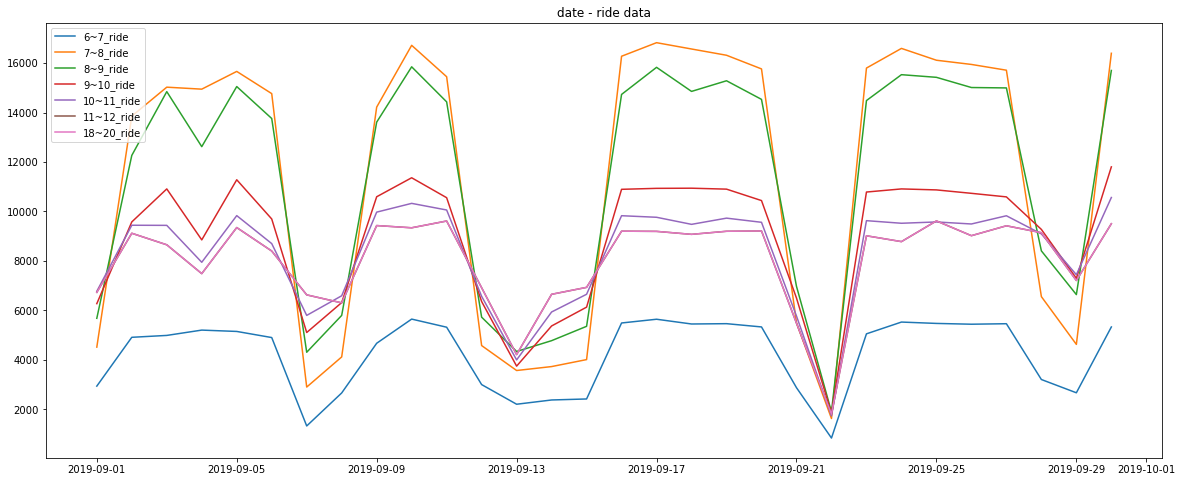

In [87]:
# 날짜별 ride 시계열 그래프
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()

for i in range (1, 8):
    ax.plot(date_ride.date, date_ride.iloc[:,i], label = date_ride.columns[i])
    
ax.legend()

plt.title("date - ride data")
plt.show()

In [107]:
import seaborn as sns

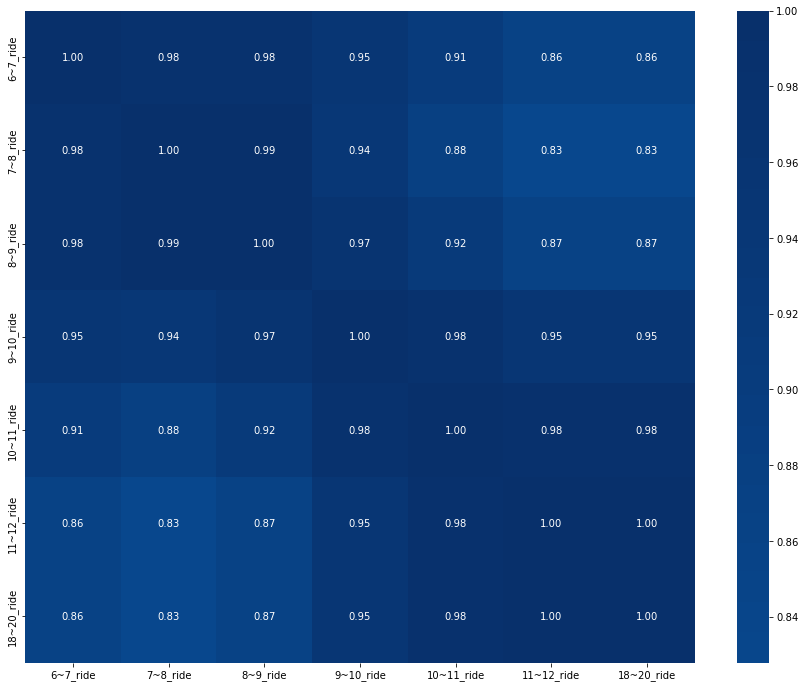

In [114]:
# date_ride 상관관계
corr1 = date_ride.corr()

fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
sns.heatmap(corr1, annot=True, fmt=".2f", cmap="Blues", center=0, ax=ax)

plt.show()

전체적으로 다 높은 상관관계를 가지고 있지만 그중에서도 11~12_ride는 상관계수 1로 매우 높다.

### 날짜별 takeoff 데이터

In [77]:
date_takeoff = pd.DataFrame({"date": pd.date_range("2019-09-01", "2019-09-30", freq="D")})

for i in range (13, 20):
    date_takeoff[train.columns[i]] = train.groupby('date')[train.columns[i]].sum().values
date_takeoff

,date,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,2019-09-01,1343.0,2713.0,3671.0,4077.0,4510.0,4604.0,11537.0
1,2019-09-02,1650.0,5358.0,7521.0,6313.0,6165.0,6251.0,20561.0
2,2019-09-03,1675.0,5824.0,9244.0,7250.0,6453.0,6091.0,19743.0
3,2019-09-04,1835.0,5755.0,7859.0,5774.0,5351.0,5020.0,20133.0
4,2019-09-05,1832.0,6152.0,9439.0,7569.0,6813.0,6607.0,20392.0
5,2019-09-06,1733.0,5951.0,9065.0,6775.0,6110.0,5725.0,8162.0
6,2019-09-07,565.0,1524.0,2585.0,3286.0,3680.0,4361.0,12389.0
7,2019-09-08,1211.0,2472.0,3583.0,4153.0,4378.0,4351.0,10306.0
8,2019-09-09,1549.0,5340.0,8250.0,6772.0,6615.0,6530.0,20135.0
9,2019-09-10,2047.0,6583.0,10078.0,7766.0,7023.0,6692.0,22805.0


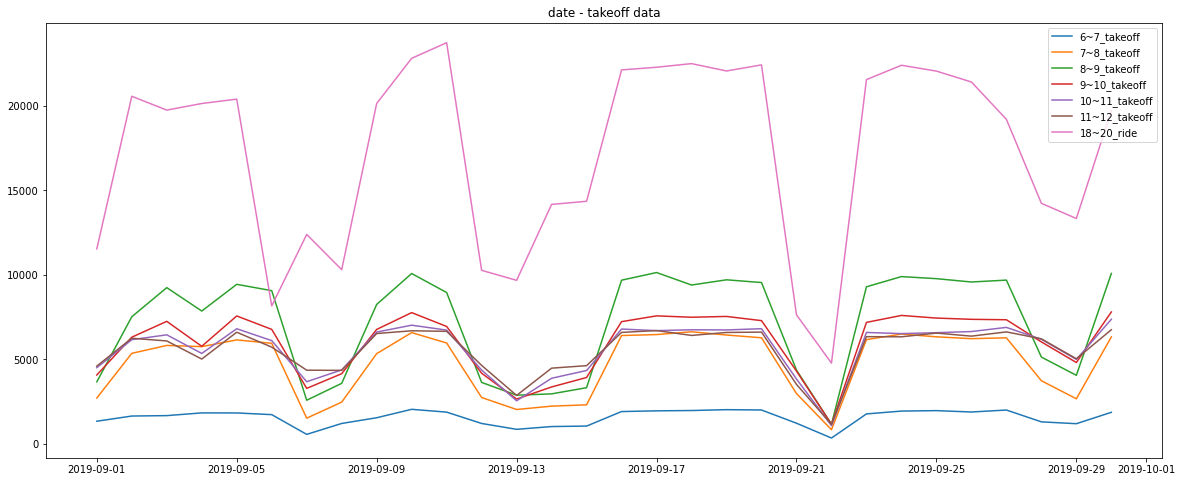

In [96]:
# 날짜별 takeoff 시계열 그래프
# 날짜별 ride 시계열 그래프
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()

for i in range (1, 8):
    ax.plot(date_takeoff.date, date_takeoff.iloc[:,i], label = date_takeoff.columns[i])
    
ax.legend()

plt.title("date - takeoff data")
plt.show()

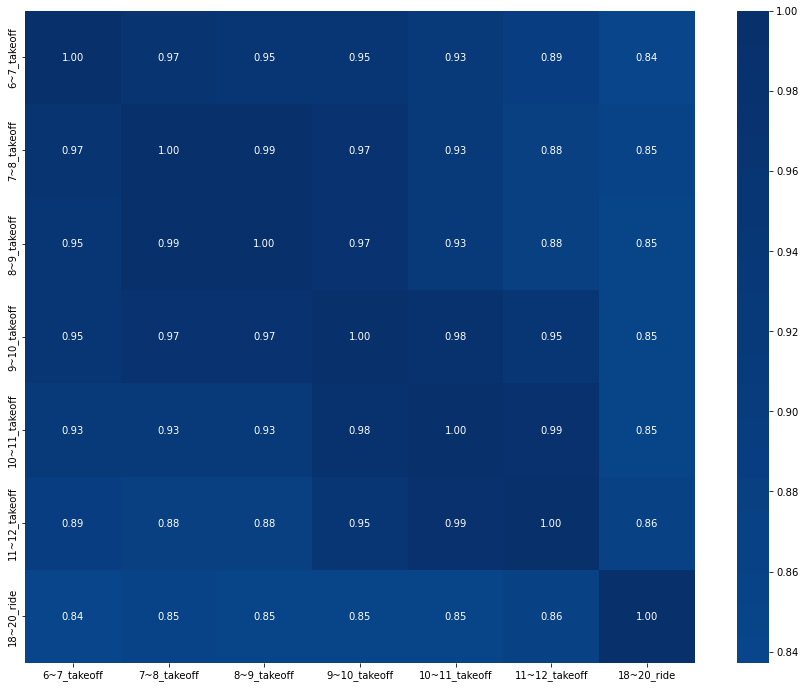

In [115]:
# date_takeoff 상관관계
corr2 = date_takeoff.corr()

fig, ax = plt.subplots()
fig.set_size_inches(15, 12)
sns.heatmap(corr2, annot=True, fmt=".2f", cmap="Blues", center=0, ax=ax)

plt.show()

18~20_ride는 전체적으로 takeoff 데이터보다 ride 데이터와 상관관계가 높다

## 우리의 목표변수인 18~20_ride 데이터만 추세/계절변동 등을 살펴봄

In [119]:
target_ts = pd.Series(date_ride["18~20_ride"].values, index=date_ride.date, name="target")

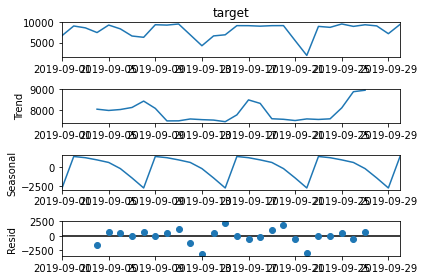

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(target_ts, model="additive")
result.plot()

plt.show()

계절변동 확실히 나타남 근데 글자가 겹침..... 대충 30일 / 4 = 7일 일주일마다 계절변동이 있는 것 같음 -> 요일별 데이터 범주형 추가  
추세는 초반에 많고 후반에 많아지는데 혹시 추석? -> 공휴일 여부 데이터  

## bus_route_id 에 따른 승객 수 차이

In [142]:
train.columns

Index(['date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

In [4]:
bus_route = pd.pivot_table(train, index="bus_route_id", values=['6~7_ride', '7~8_ride', '8~9_ride','9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff','18~20_ride'], aggfunc="sum")

In [145]:
# 결과 해석할 때 지역에 따라 노선에 따라 승객 수 높은 곳 알 수 있을 듯 
# 대체적으로 거의 비슷한 계절변동과 추세를 가지고 있기에 우리의 target 변수 기준으로 sort
bus_route.sort_values(by="18~20_ride", ascending=False)

,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,18~20_ride,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff
bus_route_id,,,,,,,,,,,,,
23610000,6660.0,4335.0,9323.0,5801.0,19734.0,1986.0,701.0,7432.0,3499.0,8177.0,5022.0,7851.0,4578.0
23620000,8571.0,5153.0,7855.0,4895.0,19494.0,2226.0,1073.0,4829.0,2145.0,6392.0,3623.0,8038.0,4845.0
23580000,5345.0,3281.0,5678.0,3720.0,16828.0,2027.0,1050.0,4386.0,2024.0,6794.0,3718.0,5312.0,3409.0
23570000,6406.0,3745.0,5695.0,3647.0,15476.0,1104.0,597.0,3626.0,1262.0,6764.0,3365.0,6942.0,4042.0
22530000,4884.0,3652.0,5213.0,3358.0,10918.0,1993.0,364.0,6174.0,2470.0,6254.0,3869.0,5645.0,3853.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30810000,0.0,1.0,119.0,93.0,0.0,0.0,0.0,83.0,10.0,248.0,192.0,0.0,1.0
30820000,0.0,0.0,57.0,12.0,0.0,22.0,5.0,0.0,11.0,44.0,2.0,52.0,87.0
28650000,11.0,19.0,13.0,7.0,0.0,2076.0,431.0,2764.0,2043.0,286.0,866.0,25.0,9.0


In [150]:
bus_route.describe()

,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,18~20_ride,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff
count,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000
mean,406.353997,276.497553,392.647635,273.022838,841.753670,207.300163,76.491028,562.277325,233.714519,552.553018,350.013051,435.398042,292.030995
std,872.952192,570.328536,879.651749,586.534619,2031.763091,356.254629,149.533693,920.049831,389.252940,1014.561771,606.163005,920.236893,575.659568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,5.000000,5.000000,4.000000,0.000000,0.000000
50%,64.000000,50.000000,53.000000,35.000000,42.000000,45.000000,6.000000,179.000000,82.000000,114.000000,89.000000,66.000000,51.000000
75%,431.000000,309.000000,363.000000,285.000000,710.000000,265.000000,93.000000,704.000000,295.000000,630.000000,437.000000,464.000000,333.000000
max,8571.000000,5153.000000,9323.000000,5801.000000,19734.000000,3358.000000,1224.000000,7432.000000,3499.000000,8177.000000,5022.000000,8038.000000,4845.000000


In [147]:
bus_route[bus_route["18~20_ride"]==0]

,10~11_ride,10~11_takeoff,11~12_ride,11~12_takeoff,18~20_ride,6~7_ride,6~7_takeoff,7~8_ride,7~8_takeoff,8~9_ride,8~9_takeoff,9~10_ride,9~10_takeoff
bus_route_id,,,,,,,,,,,,,
7990000,18.0,10.0,40.0,35.0,0.0,228.0,163.0,57.0,1.0,64.0,67.0,64.0,37.0
20050000,73.0,0.0,56.0,0.0,0.0,1.0,0.0,53.0,0.0,51.0,0.0,46.0,0.0
21020000,0.0,0.0,0.0,0.0,0.0,32.0,2.0,118.0,102.0,1.0,40.0,0.0,1.0
21040000,0.0,0.0,0.0,0.0,0.0,67.0,13.0,134.0,53.0,15.0,120.0,0.0,0.0
21070000,0.0,0.0,0.0,0.0,0.0,588.0,35.0,769.0,731.0,63.0,533.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32740000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,594.0,141.0,584.0,403.0,59.0,300.0
32760000,0.0,0.0,0.0,0.0,0.0,155.0,22.0,121.0,179.0,0.0,0.0,0.0,2.0
32770000,0.0,0.0,0.0,0.0,0.0,15.0,16.0,1.0,10.0,0.0,0.0,0.0,0.0


**우리의 target인 18~20_ride가 합해서 0인 루트가 210개나 됨 -> 다른 시간대에도 사람 없는 노선인가? -> 아니라면 결측치가 0으로 되어있는게 아닐까? -> 대체?**

In [5]:
class1820 = []
for i in range (613):
    if (bus_route["18~20_ride"].iloc[i]<=710):
        class1820.append(1)
    elif ((bus_route["18~20_ride"].iloc[i]>710) & (bus_route["18~20_ride"].iloc[i]<=7500)):
        class1820.append(2)
    elif ((bus_route["18~20_ride"].iloc[i] > 7500)):
        class1820.append(3)
bus_route["class1820"] = class1820

In [6]:
from pandas.plotting import parallel_coordinates

<AxesSubplot:>

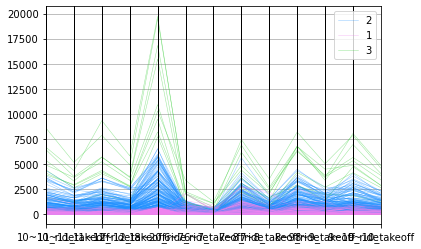

In [7]:
parallel_coordinates(bus_route,'class1820', color=('dodgerblue', 'violet', 'limegreen'), alpha=0.5, linewidth=0.5)

대체적으로 승차인원이 많은 노선도는 대체적으로 계속 승차인원이 많다. -> 18~20_ride에서 결측치는 아닌 듯함   
bus_route_id에 따른 범주형 변수도 만들어도 될 듯하다 승하차 인원 많은 곳은 계속 많은 편이니깐

## bus_bts 데이터셋과 train 데이터셋

In [126]:
bus_bts = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/bus_bts.csv", encoding="utf-8")
bus_bts

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409409,6.573162e+15,30420000,149797565,2019-10-16,07:08:31,1937,L마트,NaN,NaN,NaN,NaN,1,1
2409410,9.441160e+15,30420000,149797565,2019-10-16,07:16:31,1908,한라산교회,NaN,NaN,NaN,NaN,1,1
2409411,9.446038e+15,25070000,149797565,2019-10-16,08:29:05,1882,고도농원,NaN,NaN,NaN,NaN,1,1
2409412,4.309690e+15,25070000,149797565,2019-10-16,08:40:32,1938,주공아파트5단지,NaN,NaN,NaN,NaN,1,1


In [128]:
# 시간 간격 같은지 
train["date"].agg(["min", "max"])

min   2019-09-01
max   2019-09-30
Name: date, dtype: datetime64[ns]

In [131]:
test = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/test.csv", encoding="utf-8")
test

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,643588,2019-10-16,32820000,시내,786,고산환승정류장(고산1리),33.30073,126.18044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
228166,643589,2019-10-16,32820000,시내,1080,애월고등학교,33.46262,126.33447,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
228167,643590,2019-10-16,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228168,643591,2019-10-16,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
test["date"].agg(["min", "max"])

min    2019-10-01
max    2019-10-16
Name: date, dtype: object

In [129]:
bus_bts["geton_date"].agg(["min", "max"])

min    2019-09-01
max    2019-10-16
Name: geton_date, dtype: object

흠 . bust_bts 어케 써야할지 모르겠음,,, train이랑 겹치는 정보가 많은 것 같음 ,,,, + test랑 절반 겹침 -> 쓸수있나